## European Option
First of all, I use importance sampling method to price a deep OTM European call option.

Specifically, suppose the price of underlying asset, $S_t$ follows geometric Brownian Motion under risk-neutrual measurement $Q$:
\begin{equation}
dS_t = rS_tdt+\sigma S_tdW_t
\end{equation}

Then,
\begin{equation}
lnS_T \thicksim N(lnS_0+rT-\sigma^2T/2,\sigma^2T)
\end{equation}

and $E_QS_T=S_0e^{rT}$.

However, for the deep OTM European call option we are about to price, $E_QS_T=S_0e^{rT}$ would be much smaller than the strike price,that is, the number of paths end in the money would be low.

Therefore, we change the probability measurement to $Q_0$ under which the drift of $S_t$ is $ln(K/S_0)/T$. Then we have:
\begin{equation}
lnS_T \thicksim N(lnS_0+ln(K/S_0)-\sigma^2T/2,\sigma^2T)
\end{equation}
and $E_{Q_0}S_T=K$.

The Radon-Nikodym derivative, i.e., likelihood ratio, is:
\begin{equation}
\frac{dQ}{dQ_0}(ln(S_T/S_0))=exp{\frac{(x-ln(K/S_0)+\frac{\sigma^2T}{2})^2-(x-rT+\frac{\sigma^2T}{2})^2}{2\sigma^2T}}
\end{equation}

In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

repeats = 1*10**3

K = 115 #strike price
T = 1.
m = 50

r = 0.05
sigma = 0.15
S0 = 95.
h = T / float(m) #time interval
times = np.linspace(0, T, m+1)

normals = np.random.normal(loc=h*(r - 0.5 * sigma**2), scale=np.sqrt(h)*sigma, size=(repeats, m))
L = np.cumsum(normals, axis=1)
L = np.concatenate((np.zeros((repeats, 1)), L), axis=1)
S = S0 * np.exp(L) #price paths

vanilla_mc_option_payoff_active = S[:,-1] > K
vanilla_mc_payoffs = np.maximum(0,S[:,-1]-K) * np.exp(-r * T)
vanilla_mc_estimated_price = np.mean(vanilla_mc_payoffs)
vanilla_mc_std_err = np.std(vanilla_mc_payoffs) / np.sqrt(repeats)

vanilla_mc_df = pd.DataFrame(S.T)
vanilla_mc_df['times'] = times
vanilla_mc_df = pd.melt(vanilla_mc_df, id_vars='times')
vanilla_mc_df['variable'] = vanilla_mc_df['variable'].astype(np.int64)
vanilla_mc_df['option_payoff_active'] = vanilla_mc_option_payoff_active[vanilla_mc_df['variable'].values]


#simulation using importance sampling
normals_IS = np.random.normal(loc=h*(np.log(K/S0)/T - 0.5 * sigma**2), scale=np.sqrt(h)*sigma, size=(repeats, m))
L_IS = np.cumsum(normals_IS, axis=1)
L_IS = np.concatenate((np.zeros((repeats, 1)), L_IS), axis=1)
S_IS = S0 * np.exp(L_IS) #price paths

x = np.log(S_IS[:,-1]/S0)
p1 = (x-np.log(K/S0)+sigma**2*T/2)**2
p2 = (x-r*T+sigma**2*T/2)**2
LR = np.exp((p1 - p2)/(2*sigma**2*T)) #likelihood ratio

IS_payoff_active = S_IS[:,-1] > K
IS_payoffs = np.maximum(0,S_IS[:,-1]-K) * np.exp(-r * T) * LR
IS_estimated_price = np.mean(IS_payoffs)
IS_std_err = np.std(IS_payoffs) / np.sqrt(repeats)

IS_df = pd.DataFrame(S_IS.T)
IS_df['times'] = times
IS_df = pd.melt(IS_df, id_vars='times')
IS_df['variable'] = IS_df['variable'].astype(np.int64)
IS_df['option_payoff_active'] = IS_payoff_active[vanilla_mc_df['variable'].values]


print('Done.')

Done.


*Vanilla MC*
Total number of paths: 1000
Number of paths with positive payoff: 161
Estimated price: 1.544493453317685 +- 0.14834310487506147

-------------------------

*Importance sampling MC*
Total number of paths: 1000
Number of paths with positive payoff: 447
Estimated price: 1.3642467718205917 +- 0.05407964230593518

-------------------------

Variance improvement: 7.5243174235467505


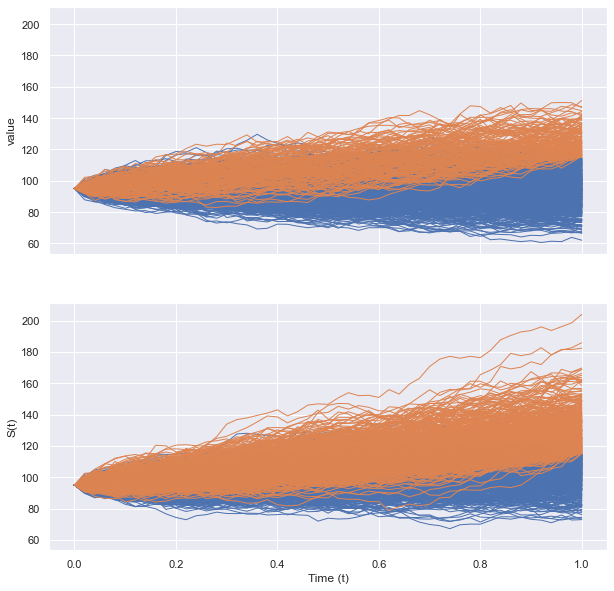

In [2]:
print('*Vanilla MC*')
print('Total number of paths: {}'.format(repeats))
print('Number of paths with positive payoff: {}'.format(np.sum(S[:,-1]>=K)))
print('Estimated price: {} +- {}'.format(vanilla_mc_estimated_price, vanilla_mc_std_err))
print('\n-------------------------\n')

print('*Importance sampling MC*')
print('Total number of paths: {}'.format(repeats))
print('Number of paths with positive payoff: {}'.format(np.sum(S_IS[:,-1]>=K)))
print('Estimated price: {} +- {}'.format(IS_estimated_price, IS_std_err))
print('\n-------------------------\n')

print('Variance improvement: {}'.format((vanilla_mc_std_err / IS_std_err)**2))

sns.set()

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
sns.lineplot(x='times', y='value', units='variable', hue='option_payoff_active', estimator=None, lw=1., data=vanilla_mc_df, legend=False, ax=axes[0])
sns.lineplot(x='times', y='value', units='variable', hue='option_payoff_active', estimator=None, lw=1., data=IS_df, legend=False, ax=axes[1])
plt.ylabel('S(t)')
plt.xlabel('Time (t)')

fig.set_size_inches(10, 10)
plt.show()

We can see from the two plots above, paths end up ITM (yellow lines) are much more when using importance sampling than using the basic Monte Carlo. Variances are improved by several times.

## Barrier Option
No we are trying to price a deep out-of-the-money down-and-in binary option. First, simulate MC paths with respect to the risk-neutral measaure.

In [3]:
repeats = 1*10**3

H = 85. #barrier
K = 105. #strike price
T = 1.
m = 50

r = 0.05
sigma = 0.15
S0 = 95.
potential_payoff = 10000.
h = T / float(m) #time interval
times = np.linspace(0, T, m+1)

normals = np.random.normal(loc=h*(r - 0.5 * sigma**2), scale=np.sqrt(h)*sigma, size=(repeats, m))
L = np.cumsum(normals, axis=1)
L = np.concatenate((np.zeros((repeats, 1)), L), axis=1)
S = S0 * np.exp(L) #price paths

vanilla_mc_option_payoff_active = np.any(S < H, axis=1) & (S[:,-1] > K)
vanilla_mc_payoffs = potential_payoff * np.exp(-r * T) * vanilla_mc_option_payoff_active
vanilla_mc_estimated_price = np.mean(vanilla_mc_payoffs)
vanilla_mc_std_err = np.std(vanilla_mc_payoffs) / np.sqrt(repeats)

vanilla_mc_df = pd.DataFrame(S.T)
vanilla_mc_df['times'] = times
vanilla_mc_df = pd.melt(vanilla_mc_df, id_vars='times')
vanilla_mc_df['variable'] = vanilla_mc_df['variable'].astype(np.int64)
vanilla_mc_df['option_payoff_active'] = vanilla_mc_option_payoff_active[vanilla_mc_df['variable'].values]

print('Done.')

Done.


Now we price the same option, but use importance sampling (change of drift). Essentially, we add a negative drift to reach the knock-in level, and once we reach it, we add a positive drift to end up in-the-money.

In [4]:
b = -np.log(H / S0)
c = np.log(K / S0)
theta_minus = 0.5 - r / sigma**2 - (2*b+c) / float(T * sigma**2)
theta_plus = 0.5 - r / sigma**2 + (2*b+c) / float(T * sigma**2)
psi_theta_plus = (r - 0.5 * sigma**2) * h * theta_plus + 0.5 * sigma**2 * h * theta_plus**2

pos_new_mean = (2*b+c)/T
neg_new_mean = -(2*b+c)/T

normals = np.random.normal(loc=h*neg_new_mean, scale=np.sqrt(h)*sigma, size=(repeats, m))
L = np.cumsum(normals, axis=1)
L = np.concatenate((np.zeros((repeats, 1)), L), axis=1)
S_tilde = S0 * np.exp(L)
below_knockin = S_tilde < H

taus = np.zeros(repeats, dtype=np.int64)

for i in range(0, repeats):
    tau = np.argmax(below_knockin[i,:])
    
    start_of_new_normals = m
    
    if tau == 0:
        taus[i] = m
    else:
        start_of_new_normals = tau + 1
        taus[i] = tau
    
    if start_of_new_normals < m:
        number_required = m - start_of_new_normals
        normals[i,start_of_new_normals:] = np.random.normal(loc=h*pos_new_mean, scale=np.sqrt(h)*sigma, size=number_required)

L = np.cumsum(normals, axis=1)
L = np.concatenate((np.zeros((repeats, 1)), L), axis=1)
S = S0 * np.exp(L)

LR = np.zeros(repeats)

for i in range(0, repeats):
    L_tau = L[i,taus[i]]
    L_m = L[i,-1]
    LR[i] = np.exp((theta_plus - theta_minus) * L_tau - theta_plus * L_m + m * psi_theta_plus)

importance_mc_option_payoff_active = np.any(S < H, axis=1) & (S[:,-1] > K)
importance_mc_payoffs = potential_payoff * np.exp(-r * T) * np.multiply(LR, importance_mc_option_payoff_active)
importance_mc_estimated_price = np.mean(importance_mc_payoffs)
importance_mc_std_err = np.std(importance_mc_payoffs) / np.sqrt(repeats)

importance_mc_df = pd.DataFrame(S.T)
importance_mc_df['times'] = times
importance_mc_df = pd.melt(importance_mc_df, id_vars='times')
importance_mc_df['variable'] = importance_mc_df['variable'].astype(np.int64)
importance_mc_df['option_payoff_active'] = importance_mc_option_payoff_active[importance_mc_df['variable'].values]

print('Done.')

Done.


Result comparison is shown below:

*Vanilla MC*
Total number of paths: 1000
Number of paths with positive payoff: 24
Estimated price: 228.29506188017135 +- 46.03793183894592

-------------------------

*Importance sampling MC*
Total number of paths: 1000
Number of paths with positive payoff: 393
Estimated price: 117.21977197816456 +- 6.389903297269036

-------------------------

Variance improvement: 51.909045086617525


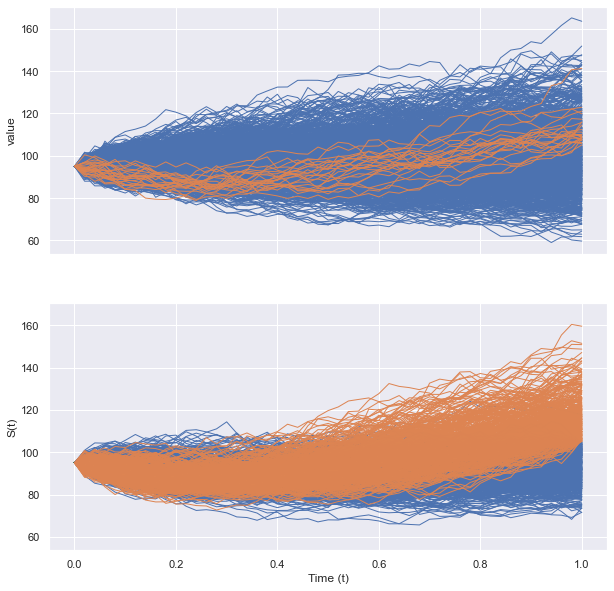

In [5]:
print('*Vanilla MC*')
print('Total number of paths: {}'.format(repeats))
print('Number of paths with positive payoff: {}'.format(np.sum(vanilla_mc_option_payoff_active)))
print('Estimated price: {} +- {}'.format(vanilla_mc_estimated_price, vanilla_mc_std_err))
print('\n-------------------------\n')

print('*Importance sampling MC*')
print('Total number of paths: {}'.format(repeats))
print('Number of paths with positive payoff: {}'.format(np.sum(importance_mc_option_payoff_active)))
print('Estimated price: {} +- {}'.format(importance_mc_estimated_price, importance_mc_std_err))
print('\n-------------------------\n')

print('Variance improvement: {}'.format((vanilla_mc_std_err / importance_mc_std_err)**2))

sns.set()

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
sns.lineplot(x='times', y='value', units='variable', hue='option_payoff_active', estimator=None, lw=1., data=vanilla_mc_df, legend=False, ax=axes[0])
sns.lineplot(x='times', y='value', units='variable', hue='option_payoff_active', estimator=None, lw=1., data=importance_mc_df, legend=False, ax=axes[1])
plt.ylabel('S(t)')
plt.xlabel('Time (t)')

fig.set_size_inches(10, 10)
plt.show()

## Asian Option
Next,price a deep out-of-the-money asian call option. First, use Vanilla Monte Carlo.

In [6]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

repeats = 1*10**3

K = 55.
T = 1.
n = 64

r = 0.05
sigma = 0.1
S0 = 50.
dt = T / float(n)
times = np.linspace(0, T, n+1)

normals = np.random.normal(loc=0, scale=1, size=(repeats, n))
scaled_normals = (r-0.5*sigma**2)*dt + normals * sigma * np.sqrt(dt)
L = np.cumsum(scaled_normals, axis=1)
L = np.concatenate((np.zeros((repeats, 1)), L), axis=1)
S = S0 * np.exp(L)

vanilla_mc_payoffs = np.exp(-r * T) * np.maximum(np.mean(S[:,1:], axis=1) - K, 0)
vanilla_mc_estimated_price = np.mean(vanilla_mc_payoffs)
vanilla_mc_std_err = np.std(vanilla_mc_payoffs) / np.sqrt(repeats)

vanilla_mc_df = pd.DataFrame(S.T)
vanilla_mc_df['times'] = times
vanilla_mc_df = pd.melt(vanilla_mc_df, id_vars='times')
vanilla_mc_df['variable'] = vanilla_mc_df['variable'].astype(np.int64)

vanilla_mc_option_payoff_active = np.mean(S[:,1:], axis=1) > K
vanilla_mc_df['option_payoff_active'] = vanilla_mc_option_payoff_active[vanilla_mc_df['variable'].values]

print('Done.')

Done.


Now we will price the same option, but we will compute an optimal change of drift. This is from the first example in Glassmerman's paper "Importance and stratified sampling for pricing path-dependent options."

First we need to compute the optimal change of drift by find the root of a nonlinear equation. We will find the root of my_func, and then use the root (y value) to get the drift vector (z value). Then once we have the optimal drift, we can run the simulations.

root: 1.8740857936943132


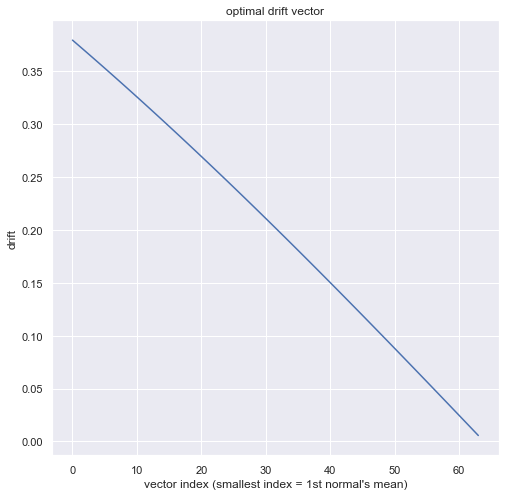

Done.


In [7]:
from scipy import optimize
from scipy.stats import norm
import matplotlib.pyplot as plt

use_stratification = True
strata = 100

repeats_per_stratum = repeats / float(strata)

def my_func(y):
    z, S = get_z_and_S(y)
    return np.mean(S) - K - y

def get_z_and_S(y):
    S = np.zeros(n + 1)
    z = np.zeros(n)
    S[0] = S0
    z[0] = sigma * np.sqrt(dt) * (y + K) / y
    
    for i in range(1, n):
        S[i] = S[i-1] * np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z[i-1])
        z[i] = z[i-1] - sigma * np.sqrt(dt) * S[i] / (n * y)
    S[-1] = S[-2] * np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z[-1])
    
    return z, S

root = optimize.brentq(my_func, 0.01, 100)
print('root: {}'.format(root))
#we assume that the root is inside of D (i.e. this S path gives a positive payoff)
#I suspect that this is always the case, but it's something to keep in mind since it's not proved
optimal_drift, S = get_z_and_S(root)

# plot the optimal drift vector
plt.plot(optimal_drift)
plt.title('optimal drift vector')
plt.xlabel('vector index (smallest index = 1st normal\'s mean)')
plt.ylabel('drift')
plt.gcf().set_size_inches(8, 8)
plt.show()

#simulate the paths under the change of drift
if use_stratification:
    uniforms = np.random.rand(repeats)
    v = np.repeat(np.arange(0, strata), repeats_per_stratum) / strata + uniforms / strata
    x = norm.ppf(v)
    Y = np.random.normal(loc=0, scale=1, size=(repeats, n))
    u = optimal_drift / np.linalg.norm(optimal_drift)
    normals = np.outer(x, u) + Y - np.outer(Y.dot(u), u) + optimal_drift
    scaled_normals = (r-0.5*sigma**2)*dt + normals * sigma * np.sqrt(dt)
else:
    normals = np.random.normal(loc=optimal_drift, scale=1, size=(repeats, n))
    scaled_normals = (r-0.5*sigma**2)*dt + normals * sigma * np.sqrt(dt)
    
L = np.cumsum(scaled_normals, axis=1)
L = np.concatenate((np.zeros((repeats, 1)), L), axis=1)
S = S0 * np.exp(L)

LR = np.exp(-1 * normals.dot(optimal_drift) + 0.5 * optimal_drift.dot(optimal_drift))
importance_mc_payoffs = np.exp(-r * T) * np.multiply(np.maximum(np.mean(S[:,1:], axis=1) - K, 0), LR)
importance_mc_estimated_price = np.mean(importance_mc_payoffs)

importance_mc_std_err = None

if use_stratification:
    payoffs_by_stratum = np.resize(importance_mc_payoffs, (strata, int(repeats_per_stratum)))
    q = repeats_per_stratum / float(repeats)
    stratification_var = np.sum(np.var(payoffs_by_stratum, axis=1)) * (q**2) / repeats_per_stratum
    importance_mc_std_err = np.sqrt(stratification_var)
else:
    importance_mc_std_err = np.std(importance_mc_payoffs) / np.sqrt(repeats)
    
importance_mc_df = pd.DataFrame(S.T)
importance_mc_df['times'] = times
importance_mc_df = pd.melt(importance_mc_df, id_vars='times')
importance_mc_df['variable'] = importance_mc_df['variable'].astype(np.int64)

importance_mc_option_payoff_active = np.mean(S[:,1:], axis=1) > K
importance_mc_df['option_payoff_active'] = importance_mc_option_payoff_active[importance_mc_df['variable'].values]

print('Done.')

Result comparsion is shown below:

*Vanilla MC*
Total number of paths: 1000
Number of paths with positive payoff: 113
Estimated price: 0.17631804272605597 +- 0.021903621153019324

-------------------------

*Importance sampling MC*
Total number of paths: 1000
Number of paths with positive payoff: 728
Estimated price: 0.17451479826013208 +- 0.00016175640265690954

-------------------------

Variance improvement: 18336.18063156052


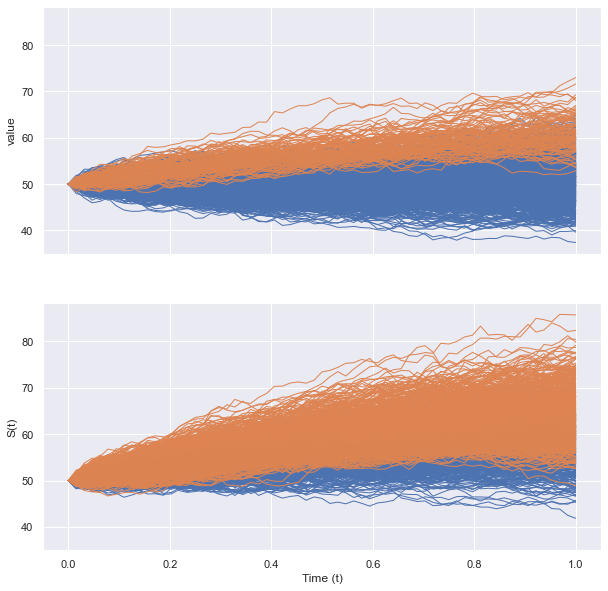

In [8]:
print('*Vanilla MC*')
print('Total number of paths: {}'.format(repeats))
print('Number of paths with positive payoff: {}'.format(np.sum(vanilla_mc_option_payoff_active)))
print('Estimated price: {} +- {}'.format(vanilla_mc_estimated_price, vanilla_mc_std_err))
print('\n-------------------------\n')
print('*Importance sampling MC*')
print('Total number of paths: {}'.format(repeats))
print('Number of paths with positive payoff: {}'.format(np.sum(importance_mc_option_payoff_active)))
print('Estimated price: {} +- {}'.format(importance_mc_estimated_price, importance_mc_std_err))
print('\n-------------------------\n')

print('Variance improvement: {}'.format((vanilla_mc_std_err / importance_mc_std_err)**2))

sns.set()

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
sns.lineplot(x='times', y='value', units='variable', hue='option_payoff_active', estimator=None, lw=1., data=vanilla_mc_df, legend=False, ax=axes[0])
sns.lineplot(x='times', y='value', units='variable', hue='option_payoff_active', estimator=None, lw=1., data=importance_mc_df, legend=False, ax=axes[1])
plt.ylabel('S(t)')
plt.xlabel('Time (t)')

fig.set_size_inches(10, 10)
plt.show()